In [21]:
import os
import pickle
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.applications.resnet_v2 import preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.layers import Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD

# Data Preperation

In [22]:
# Define paths to your training and testing directories
data_dir = 'Datasets/combined_dataset_processed_224_3'

# Function to add images from a directory to a list
def process_directory(directory, data_list):
    for class_name in os.listdir(directory):
        class_dir = os.path.join(directory, class_name)

        # Check if it's a directory
        if os.path.isdir(class_dir):
            # Loop through each image in the folder
            for image_name in os.listdir(class_dir):
                image_path = os.path.join(class_dir, image_name)
                # For test purposes use only processed images that DeepFace classifies correctly
                # processed_image_path = image_path.replace('combined_dataset_deepface', 'combined_dataset_processed')
                # Append to the data list
                data_list.append({'filepath': image_path, 'label': class_name})

# Initialize an empty list for storing data
data_list = []
# Add training images to the data list
process_directory(data_dir, data_list)
# Create a DataFrame from the list
df = pd.DataFrame(data_list)
# Shuffle the DataFrame
df = df.sample(frac=1).reset_index(drop=True)
# Print the amount of images per category before balancing
print("Images per category:")
print(df['label'].value_counts())

# Split the data into training, validation, and test sets
train_df, temp_test_val_df = train_test_split(df, train_size=0.7, random_state=42)
test_df, val_df = train_test_split(temp_test_val_df, test_size=0.5, random_state=42)

# Balance the test and validation sets
# Determine the smallest class size within each of the test and validation sets
min_test_class_size = test_df['label'].value_counts().min()
min_val_class_size = val_df['label'].value_counts().min()

# Determine the smallest size between the two for a uniform approach
uniform_min_size = min(min_test_class_size, min_val_class_size)

# Function to reduce class sizes
def balance_classes(df, target_size):
    balanced_df = pd.DataFrame()  # Initialize an empty DataFrame to hold the balanced data
    for label in df['label'].unique():
        subset = df[df['label'] == label].sample(n=target_size, random_state=42)
        balanced_df = pd.concat([balanced_df, subset])
    return balanced_df

# Apply balancing
test_df = balance_classes(test_df, uniform_min_size)
val_df = balance_classes(val_df, uniform_min_size)

# Calculate and print split ratios
total_samples = len(df)
train_ratio = len(train_df) / total_samples
val_ratio = len(val_df) / total_samples
test_ratio = len(test_df) / total_samples

print(f"\nTotal samples: {total_samples}")
print(f"Training set: {train_ratio:.2f} ({len(train_df)} samples)")
print(f"Validation set: {val_ratio:.2f} ({len(val_df)} samples)")
print(f"Test set: {test_ratio:.2f} ({len(test_df)} samples)\n")

Images per category:
label
happy       17299
neutral     12928
sad         11161
angry        9415
surprise     9302
fear         8649
disgust      4767
Name: count, dtype: int64

Total samples: 73521
Training set: 0.70 (51464 samples)
Validation set: 0.07 (4886 samples)
Test set: 0.07 (4886 samples)


# Preprocessing

In [30]:
# Set the image size and batch size
image_size = (224, 224) # Can be increased to improve accuracy or decreased to improve speed. (48, 48) for FER2013, (224, 224) for RAF-DB
batch_size = 64

# Create an ImageDataGenerator for data augmentation (optional)
train_datagen = ImageDataGenerator(
    rescale=1./255, # Normalize pixel values to [0, 1]
    # rotation_range=15,  # rotation. Not needed since all images are getting aligned
    width_shift_range=0.05, # horizontal shift (only 5% since faces are centered)
    height_shift_range=0.05, # vertical shift (only 5% since faces are centered)
    shear_range=0.1, 
    # zoom_range=0.1,   zoom (with current dataset not needed, since faces are centered)
    horizontal_flip=True, # flip images horizontally
    fill_mode='constant', # fill in missing pixels (nearest / constant)
    # brightness_range=[0.8, 1.2] # darken and lighten images
)

val_datagen = ImageDataGenerator(rescale=1./255)  # No augmentation for validation data
test_datagen = ImageDataGenerator(rescale=1./255)  # No augmentation for test data

# Create generators
train_generator = train_datagen.flow_from_dataframe(
    preprocessing_function=preprocess_input,
    dataframe=train_df,
    x_col='filepath',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='filepath',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filepath',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical',
    shuffle=False
)

# Compute class weights
# Assuming 'labels' contains your class labels for the training data
labels = train_df['label'].values
unique_classes = np.unique(labels)
# Compute class weights for balanced training
class_weights = compute_class_weight('balanced', classes=unique_classes, y=labels)
# Get class indices from the generator
class_indices = train_generator.class_indices
# Ensure the order of `unique_classes` matches the order in `class_indices`
ordered_unique_classes = sorted(unique_classes, key=lambda x: class_indices[x])
# Create a dictionary mapping class indices to their weights
class_weights_dict = {class_indices[label]: weight for label, weight in zip(ordered_unique_classes, class_weights)}
print(class_weights_dict)

Found 51464 validated image filenames belonging to 7 classes.
Found 4886 validated image filenames belonging to 7 classes.
Found 4886 validated image filenames belonging to 7 classes.
{0: 1.1161378472749355, 1: 2.1998803111909035, 2: 1.2172185430463576, 3: 0.6044064452482736, 4: 0.8135443178045811, 5: 0.943289710033359, 6: 1.131076923076923}


# Image before and after preprocessing comparison

In [29]:
# Create a non-preprocessing ImageDataGenerator
no_preprocessing_datagen = ImageDataGenerator()

# Create a temporary generator to fetch a batch of original images
temp_generator = no_preprocessing_datagen.flow_from_directory(
    data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True  # Keep the same order as the original generator
)

# Function to plot images in a grid
def plot_images_before(images_arr):
    fig, axes = plt.subplots(5, 5, figsize=(12, 12))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img.astype('uint8'))  # Cast to uint8 for correct image display
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Fetch a batch of original images
original_batch = next(temp_generator)
original_images = original_batch[0][:25]  # Select first 25 images

# Function to plot images in a grid
def plot_images_after(images_arr):
    fig, axes = plt.subplots(5, 5, figsize=(12, 12))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img, cmap='gray')  # Set the colormap to 'gray'
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Get a batch of images
example_batch = next(train_generator)
example_images = example_batch[0][:25]  # Select first 25 images

# Plot the images
# plot_images_before(original_images)
# plot_images_after(example_images)

Found 73521 images belonging to 7 classes.


## ResNet50V2
ResNet50V2 expects 224x224 input

In [14]:
# Load the ResNet50V2 model
base_model = ResNet50V2(weights=None, include_top=False, input_shape=(224, 224, 3))
base_model.load_weights('PretrainedModels/resnet50v2_weights_tf_dim_ordering_tf_kernels_notop.h5')

# Freeze the layers except the last 4 layers
for layer in base_model.layers[:-4]:
    layer.trainable = False

# Add custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
predictions = Dense(7, activation='softmax')(x)  # Assuming 7 emotions

# Create the final model
model_resnet50v2 = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model_resnet50v2.compile(optimizer=Adam(learning_rate=0.0002), loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary
model_resnet50v2.summary()

## VGG-16

In [31]:
# Load the VGG16 model
base_model = VGG16(weights=None, include_top=False, input_shape=(224, 224, 3))
base_model.load_weights('PretrainedModels/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5')

# Freeze the layers except the last 4 layers
for layer in base_model.layers[:-4]:
    layer.trainable = False

# Add custom top layers for FER
x = base_model.output
x = Flatten()(x)  # Flatten the output layer to 1 dimension
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)  # Add batch normalization
x = Dropout(0.5)(x)  # Add dropout
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)  # Add batch normalization
x = Dropout(0.5)(x)  # Add dropout
predictions = Dense(7, activation='softmax')(x)  # Assuming 7 emotions

# Compile the model
model_vgg16 = Model(inputs=base_model.input, outputs=predictions)
model_vgg16.compile(optimizer=Adam(learning_rate=0.003), loss='categorical_crossentropy', metrics=['accuracy'])

model_vgg16.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

## MobileNetV2

In [42]:
# Load the MobileNetV2
base_model = MobileNetV2(weights=None, include_top=False, input_shape=(224, 224, 3))
base_model.load_weights('PretrainedModels/mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_224_no_top.h5')

# Freeze the layers of the base model
for layer in base_model.layers[:-4]:
    layer.trainable = False

# Add custom top layers for FER
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)  # Add batch normalization
x = Dropout(0.5)(x)  # Add dropout to prevent overfitting
predictions = Dense(7, activation='softmax')(x)  # Assuming 7 emotions

# Compile the model
model_mobilenetv2 = Model(inputs=base_model.input, outputs=predictions)
model_mobilenetv2.compile(optimizer=Adam(learning_rate=0.0002), loss='categorical_crossentropy', metrics=['accuracy'])

model_mobilenetv2.summary()

Exception: URL fetch failure on https://storage.googleapis.com/tensorflow/keras-applications/mobilenet_v2/mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_224_no_top.h5: None -- [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1006)

# EfficientNetB0

In [43]:
# Load the EfficientNetB0 model
base_model = EfficientNetB0(weights=None, include_top=False, input_shape=(224, 224, 3))
base_model.load_weights('PretrainedModels/efficientnetb0_notop.h5')

# Freeze the layers of the base model
for layer in base_model.layers[:-4]:
    layer.trainable = False

# Add custom top layers for FER
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)  # Add batch normalization
x = Dropout(0.5)(x)  # Add dropout
predictions = Dense(7, activation='softmax')(x)  # Assuming 7 emotions

# Compile the model
model_efficientnetb0 = Model(inputs=base_model.input, outputs=predictions)
model_efficientnetb0.compile(optimizer=SGD(learning_rate=0.005), loss='categorical_crossentropy', metrics=['accuracy'])

model_efficientnetb0.summary()

Exception: URL fetch failure on https://storage.googleapis.com/keras-applications/efficientnetb0_notop.h5: None -- [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1006)

# DenseNet121

In [46]:
# Load the DenseNet121
base_model = DenseNet121(weights=None, include_top=False, input_shape=(224, 224, 3))
base_model.load_weights('PretrainedModels/densenet121_weights_tf_dim_ordering_tf_kernels_notop.h5')

# Freeze the layers of the base model
for layer in base_model.layers[:-4]:
    layer.trainable = False

# Add custom top layers for FER
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)  # Add batch normalization
x = Dropout(0.5)(x)  # Add dropout to prevent overfitting
predictions = Dense(7, activation='softmax')(x)  # Assuming 7 emotions

# Compile the model
model_densenet121 = Model(inputs=base_model.input, outputs=predictions)
model_densenet121.compile(optimizer=Adam(learning_rate=0.0002), loss='categorical_crossentropy', metrics=['accuracy'])

model_densenet121.summary()

Exception: URL fetch failure on https://storage.googleapis.com/tensorflow/keras-applications/densenet/densenet121_weights_tf_dim_ordering_tf_kernels_notop.h5: None -- [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1006)

# Callbacks

In [33]:
# Early stopping to prevent overfitting. This stops training when the model's performance on the validation set starts to degrade.
early_stopper = EarlyStopping(
    monitor='val_loss',  # Metric to be monitored
    patience=3,         # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restores model weights from the epoch with the best value of the monitored metric
)

# ModelCheckpoint callback
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
checkpoint = ModelCheckpoint(
    f'logs/model_checkpoint_vgg16_{timestamp}.keras',  # Path where to save the model
    monitor='val_loss',     # Metric to monitor
    save_best_only=False,    # Save only the best model. Set False to save the model at the end of every epoch so restarting from specific epoch is possible
    save_weights_only=False, # Save only the weights
    mode='min',             # Minimize the monitored metric (val_loss) min before
    verbose=1               # Verbose output
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=2,
    min_lr=0.0001,
    cooldown=3,
    verbose=1
)

# Model Training

In [34]:
model = model_vgg16
epochs = 30  # When resuming training, set epochs to the total number of epochs you want to train, not just the additional epochs. The model.fit() method continues training for the specified number of epochs, starting from the current epoch count.

# Load the last saved weights
# model.load_weights('logs/model_checkpoint_20240225_085054.keras')

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    class_weight=class_weights_dict,
    callbacks=[early_stopper, checkpoint, reduce_lr]
)

# Save the training history for later analysis
with open(f'logs/training_history_vgg16_{timestamp}.pkl', 'wb') as file:
    pickle.dump(history.history, file)

Epoch 1/30
804/804 [==============================] - ETA: 0s - loss: 1.8814 - accuracy: 0.3857
Epoch 1: saving model to logs/model_checkpoint_vgg16_20240303_164544.keras
804/804 [==============================] - 5742s 7s/step - loss: 1.8814 - accuracy: 0.3857 - val_loss: 1.3649 - val_accuracy: 0.4944 - lr: 2.0000e-04
Epoch 2/30
804/804 [==============================] - ETA: 0s - loss: 1.4129 - accuracy: 0.4945
Epoch 2: saving model to logs/model_checkpoint_vgg16_20240303_164544.keras
804/804 [==============================] - 5663s 7s/step - loss: 1.4129 - accuracy: 0.4945 - val_loss: 1.3514 - val_accuracy: 0.5008 - lr: 2.0000e-04
Epoch 3/30
804/804 [==============================] - ETA: 0s - loss: 1.2855 - accuracy: 0.5415
Epoch 3: saving model to logs/model_checkpoint_vgg16_20240303_164544.keras
804/804 [==============================] - 6061s 8s/step - loss: 1.2855 - accuracy: 0.5415 - val_loss: 1.1954 - val_accuracy: 0.5561 - lr: 2.0000e-04
Epoch 4/30


KeyboardInterrupt: 

# Evaluation and Visualization

77/77 [==============================] - 535s 7s/step - loss: 1.2263 - accuracy: 0.5274
Test accuracy:  0.5274252891540527
77/77 [==============================] - 522s 7s/step
Classification Report
              precision    recall  f1-score   support

       angry       0.54      0.45      0.49       698
     disgust       0.59      0.46      0.52       698
        fear       0.53      0.30      0.38       698
       happy       0.78      0.75      0.76       698
     neutral       0.49      0.47      0.48       698
         sad       0.44      0.45      0.45       698
    surprise       0.43      0.82      0.57       698

    accuracy                           0.53      4886
   macro avg       0.54      0.53      0.52      4886
weighted avg       0.54      0.53      0.52      4886

Weighted Precision: 0.5431711709117063
Weighted Recall: 0.5274252967662709
Weighted F1-Score: 0.520457394302964


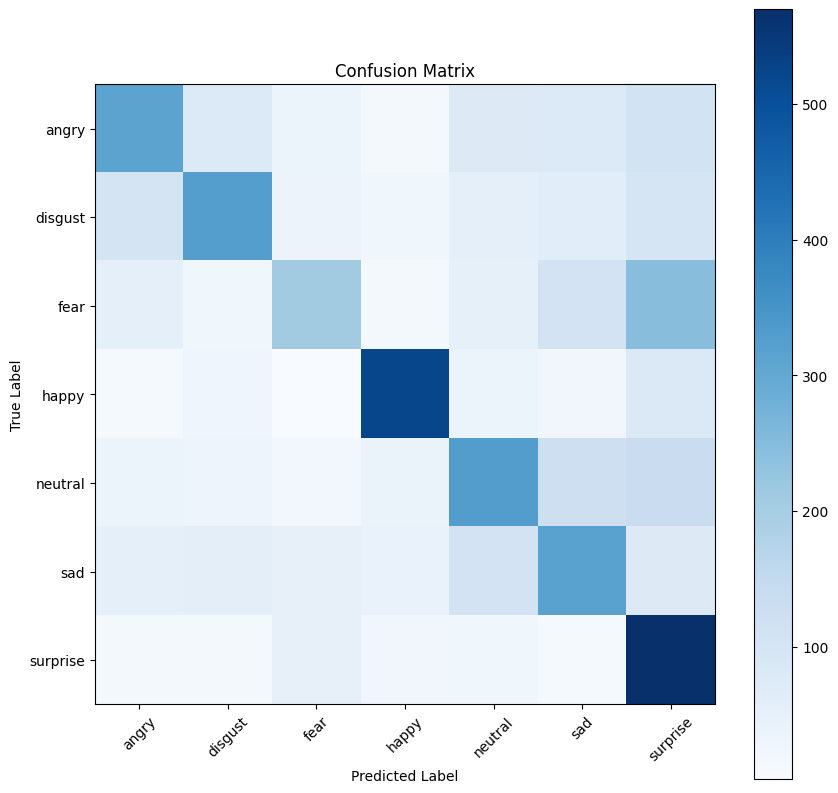

In [35]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator, steps=np.ceil(test_generator.samples / test_generator.batch_size))
print("Test accuracy: ", test_accuracy)

# Predictions on the test set
test_generator.reset() # Ensuring the generator is reset to the beginning
predictions = model.predict(test_generator, steps=np.ceil(test_generator.samples / test_generator.batch_size))
predicted_classes = np.argmax(predictions, axis=1) # Convert predictions to class labels

# Since the generator omits some samples due to rounding down in 'steps',  trim 'true_classes' to match 'predicted_classes' length
true_classes = test_generator.classes
true_classes = true_classes[:len(predicted_classes)]

class_labels = list(test_generator.class_indices.keys())

# Classification report
print("Classification Report")
print(classification_report(true_classes, predicted_classes, target_names=class_labels, zero_division=0))

# Additional weighted metric calculations
weighted_precision = precision_score(true_classes, predicted_classes, average='weighted')
weighted_recall = recall_score(true_classes, predicted_classes, average='weighted')
weighted_f1 = f1_score(true_classes, predicted_classes, average='weighted')

print("Weighted Precision:", weighted_precision)
print("Weighted Recall:", weighted_recall)
print("Weighted F1-Score:", weighted_f1)

# Confusion Matrix
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

Conducting error analysis
This can be done by examining misclassified examples, which can provide insights into what types of errors the model is making

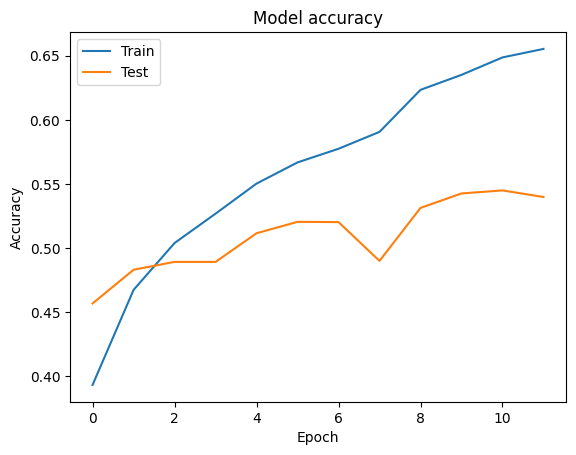

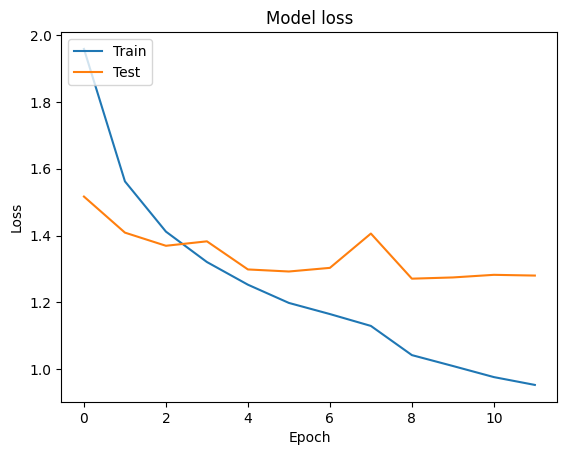

In [36]:
# Learning Curves
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

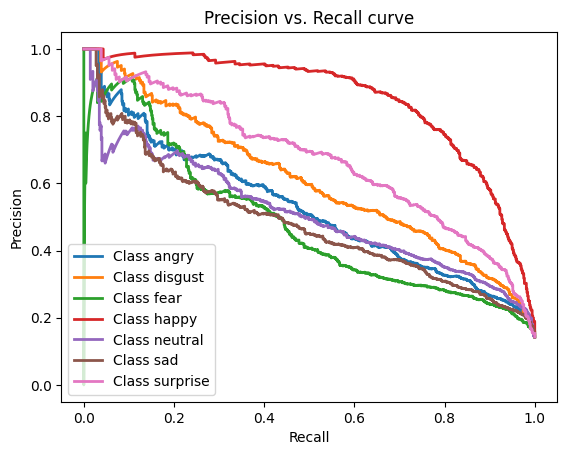

In [37]:
# Precsion-Recall Curve
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import label_binarize

# Binarize the labels for multi-class
y_bin = label_binarize(true_classes, classes=np.arange(len(class_labels)))
n_classes = y_bin.shape[1]

# Compute precision-recall curve for each class
precision = dict()
recall = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_bin[:, i], predictions[:, i])

# Plot the precision-recall curve
for i in range(n_classes):
    plt.plot(recall[i], precision[i], lw=2, label='Class {}'.format(class_labels[i]))

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="best")
plt.title("Precision vs. Recall curve")
plt.show()

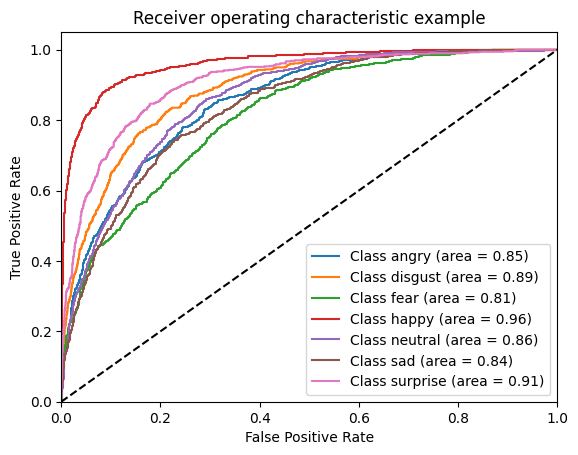

In [38]:
# ROC Curve and AUC
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='Class {} (area = {:.2f})'.format(class_labels[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()